In [119]:
import h5py as h5
import matplotlib.pyplot as plt
import os
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import sys
sys.path.append(os.path.expanduser("~/TMPredictor/survival_tm/auton-survival"))
from auton_survival.preprocessing import Scaler
import optuna
from sklearn.model_selection import ParameterGrid
#sys.path.append('/projects/EKOLEMEN/survival_tm/train_models/auton-survival')
sys.path.append(os.path.expanduser("~/TMPredictor/survival_tm/auton-survival"))
from sklearn.model_selection import ParameterGrid
from auton_survival.estimators import SurvivalModel
from auton_survival.metrics import survival_regression_metric
from auton_survival.models.dsm.dsm_torch import DeepSurvivalMachinesTorch
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc

In [121]:
'''with open('models/pca_hyperparams.pkl', 'rb') as file:
    loaded_model = pickle.load(file)[1][0]'''
with open('models/dummy.pkl', 'rb') as f:
    loaded_model = pickle.load(f)[0][0]

In [4]:
with open('data/x_train_pca.pkl', 'rb') as f:
    x_train_df = pickle.load(f)

In [122]:
a = loaded_model._model._gen_torch_model(38, 'Adam', 1)
#torch.save(a, 'temp.pth')
print(a.embedding)
#print(a.act)
print(a.shapeg['1'])
#print(a.shape['1'].expand(179, -1))
print(a.scaleg['1'])
#print(a.scale['1'].expand(179, -1))
print(a.gate['1'])
print(a.temp)

Sequential(
  (0): Linear(in_features=38, out_features=10, bias=False)
  (1): ReLU6()
  (2): Linear(in_features=10, out_features=50, bias=False)
  (3): ReLU6()
)
Sequential(
  (0): Linear(in_features=50, out_features=10, bias=True)
)
Sequential(
  (0): Linear(in_features=50, out_features=10, bias=True)
)
Sequential(
  (0): Linear(in_features=50, out_features=10, bias=False)
)
1.0


In [124]:
import torch
import torch.nn as nn

# Assuming 'a' is your original model
class EmbeddingModel(nn.Module):
    def __init__(self, original_model):
        super(EmbeddingModel, self).__init__()
        self.embedding = original_model.embedding
        # onnx2keras doesn't support relu6
        self.embedding[1] = nn.ReLU()
        self.embedding[3] = nn.ReLU()
        #self.embedding[5] = nn.ReLU()
        #self.embedding[7] = nn.ReLU()
        #self.embedding[9] = nn.ReLU()
    def forward(self, x):
        return self.embedding(x)

class ShapegModel(nn.Module):
    def __init__(self, original_model):
        super(ShapegModel, self).__init__()
        self.shapeg = original_model.shapeg['1']  # Access the specific module

    def forward(self, x):
        return self.shapeg(x)
    
class ScalegModel(nn.Module):
    def __init__(self, original_model):
        super(ScalegModel, self).__init__()
        self.scaleg = original_model.scaleg['1']  # Access the specific module

    def forward(self, x):
        return self.scaleg(x)
    
class GateModel(nn.Module):
    def __init__(self, original_model):
        super(GateModel, self).__init__()
        self.gate = original_model.gate['1']  # Access the specific module

    def forward(self, x):
        return self.gate(x)

scaleg = ScalegModel(a)
gate = GateModel(a)
shapeg = ShapegModel(a)
embedding = EmbeddingModel(a)

In [126]:
import onnx

# make a dummy input with the correct dimensions for your model
dummy_input = torch.randn(1, 38)
torch.onnx.export(embedding, dummy_input, 'embedding.onnx', verbose=True, input_names = ['input'], output_names = ['output'])

def sanitize_name(name):
    return name.lstrip('/').replace('/', '_').replace('.', '_')

def rename_nodes(model):
    for node in model.graph.node:
        node.name = sanitize_name(node.name)
        node.input[:] = [sanitize_name(inp) for inp in node.input]
        node.output[:] = [sanitize_name(out) for out in node.output]
    for input in model.graph.input:
        input.name = sanitize_name(input.name)
    for output in model.graph.output:
        output.name = sanitize_name(output.name)
    for initializer in model.graph.initializer:
        initializer.name = sanitize_name(initializer.name)

onnx_model = onnx.load('embedding.onnx')
rename_nodes(onnx_model)
onnx.save(onnx_model, 'sanitized_embedding.onnx')

from onnx2keras import onnx_to_keras
import onnx
onnx_model = onnx.load('sanitized_embedding.onnx')

keras_model = onnx_to_keras(onnx_model, ['input'])
keras_model.save('tape_dummy_embedding.h5')

INFO:onnx2keras:Converter is called.
DEBUG:onnx2keras:List input shapes:
DEBUG:onnx2keras:None
DEBUG:onnx2keras:List inputs:
DEBUG:onnx2keras:Input 0 -> input.
DEBUG:onnx2keras:List outputs:
DEBUG:onnx2keras:Output 0 -> output.
DEBUG:onnx2keras:Gathering weights to dictionary.
DEBUG:onnx2keras:Found weight onnx::MatMul_9 with shape (38, 10).
DEBUG:onnx2keras:Found weight onnx::MatMul_10 with shape (10, 50).
DEBUG:onnx2keras:Found input input with shape [38]
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: MatMul
DEBUG:onnx2keras:node_name: embedding_embedding_0_MatMul_output_0
DEBUG:onnx2keras:node_params: {'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name input).
DEBUG:onnx2keras:Check input 1 (name onnx::MatMul_9).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as

Exported graph: graph(%input : Float(1, 38, strides=[38, 1], requires_grad=0, device=cpu),
      %onnx::MatMul_9 : Float(38, 10, strides=[1, 38], requires_grad=0, device=cpu),
      %onnx::MatMul_10 : Float(10, 50, strides=[1, 10], requires_grad=0, device=cpu)):
  %/embedding/embedding.0/MatMul_output_0 : Float(1, 10, strides=[10, 1], requires_grad=1, device=cpu) = onnx::MatMul[onnx_name="/embedding/embedding.0/MatMul"](%input, %onnx::MatMul_9), scope: __main__.EmbeddingModel::/torch.nn.modules.container.Sequential::embedding/torch.nn.modules.linear.Linear::embedding.0 # /home/hf8585/.conda/envs/torch/lib/python3.11/site-packages/torch/nn/modules/linear.py:116:0
  %/embedding/embedding.1/Relu_output_0 : Float(1, 10, strides=[10, 1], requires_grad=1, device=cpu) = onnx::Relu[onnx_name="/embedding/embedding.1/Relu"](%/embedding/embedding.0/MatMul_output_0), scope: __main__.EmbeddingModel::/torch.nn.modules.container.Sequential::embedding/torch.nn.modules.activation.ReLU::embedding.1 # /h

/home/hf8585/.conda/envs/torch/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [127]:
# convert relu to relu6 in keras model
from keras.models import Sequential
from keras.layers import ReLU

# Assume 'model' is your pre-loaded Keras sequential model
for i, layer in enumerate(keras_model.layers):
    if isinstance(layer, ReLU):
        keras_model.layers[i] = ReLU(max_value=6, name=layer.name)  # Replacing ReLU with ReLU6

# Save the updated model if necessary
keras_model.save('tape_dummy_embedding.h5')


In [129]:
import onnx

# make a dummy input with the correct dimensions for your model
dummy_input = torch.randn(1, 50)
torch.onnx.export(scaleg, dummy_input, 'scaleg.onnx', verbose=True, input_names = ['input'], output_names = ['output'])

def sanitize_name(name):
    return name.lstrip('/').replace('/', '_').replace('.', '_')

def rename_nodes(model):
    for node in model.graph.node:
        node.name = sanitize_name(node.name)
        node.input[:] = [sanitize_name(inp) for inp in node.input]
        node.output[:] = [sanitize_name(out) for out in node.output]
    for input in model.graph.input:
        input.name = sanitize_name(input.name)
    for output in model.graph.output:
        output.name = sanitize_name(output.name)
    for initializer in model.graph.initializer:
        initializer.name = sanitize_name(initializer.name)

onnx_model = onnx.load('scaleg.onnx')
rename_nodes(onnx_model)
onnx.save(onnx_model, 'sanitized_scaleg.onnx')

from onnx2keras import onnx_to_keras
import onnx
onnx_model = onnx.load('sanitized_scaleg.onnx')

keras_model = onnx_to_keras(onnx_model, ['input'])
keras_model.save('tape_dummy_scaleg.h5')

INFO:onnx2keras:Converter is called.
DEBUG:onnx2keras:List input shapes:
DEBUG:onnx2keras:None
DEBUG:onnx2keras:List inputs:
DEBUG:onnx2keras:Input 0 -> input.
DEBUG:onnx2keras:List outputs:
DEBUG:onnx2keras:Output 0 -> output.
DEBUG:onnx2keras:Gathering weights to dictionary.
DEBUG:onnx2keras:Found weight scaleg_0_weight with shape (10, 50).
DEBUG:onnx2keras:Found weight scaleg_0_bias with shape (10,).
DEBUG:onnx2keras:Found input input with shape [50]
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Gemm
DEBUG:onnx2keras:node_name: output
DEBUG:onnx2keras:node_params: {'alpha': 1.0, 'beta': 1.0, 'transB': 1, 'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name input).
DEBUG:onnx2keras:Check input 1 (name scaleg_0_weight).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, ad

Exported graph: graph(%input : Float(1, 50, strides=[50, 1], requires_grad=0, device=cpu),
      %scaleg.0.weight : Float(10, 50, strides=[50, 1], requires_grad=1, device=cpu),
      %scaleg.0.bias : Float(10, strides=[1], requires_grad=1, device=cpu)):
  %output : Float(1, 10, strides=[10, 1], requires_grad=1, device=cpu) = onnx::Gemm[alpha=1., beta=1., transB=1, onnx_name="/scaleg/scaleg.0/Gemm"](%input, %scaleg.0.weight, %scaleg.0.bias), scope: __main__.ScalegModel::/torch.nn.modules.container.Sequential::scaleg/torch.nn.modules.linear.Linear::scaleg.0 # /home/hf8585/.conda/envs/torch/lib/python3.11/site-packages/torch/nn/modules/linear.py:116:0
  return (%output)



In [130]:
import onnx

# make a dummy input with the correct dimensions for your model
dummy_input = torch.randn(1, 50)
torch.onnx.export(shapeg, dummy_input, 'shapeg.onnx', verbose=True, input_names = ['input'], output_names = ['output'])

def sanitize_name(name):
    return name.lstrip('/').replace('/', '_').replace('.', '_')

def rename_nodes(model):
    for node in model.graph.node:
        node.name = sanitize_name(node.name)
        node.input[:] = [sanitize_name(inp) for inp in node.input]
        node.output[:] = [sanitize_name(out) for out in node.output]
    for input in model.graph.input:
        input.name = sanitize_name(input.name)
    for output in model.graph.output:
        output.name = sanitize_name(output.name)
    for initializer in model.graph.initializer:
        initializer.name = sanitize_name(initializer.name)

onnx_model = onnx.load('shapeg.onnx')
rename_nodes(onnx_model)
onnx.save(onnx_model, 'sanitized_shapeg.onnx')

from onnx2keras import onnx_to_keras
import onnx
onnx_model = onnx.load('sanitized_shapeg.onnx')

keras_model = onnx_to_keras(onnx_model, ['input'])
keras_model.save('tape_dummy_shapeg.h5')

INFO:onnx2keras:Converter is called.
DEBUG:onnx2keras:List input shapes:
DEBUG:onnx2keras:None
DEBUG:onnx2keras:List inputs:
DEBUG:onnx2keras:Input 0 -> input.
DEBUG:onnx2keras:List outputs:
DEBUG:onnx2keras:Output 0 -> output.
DEBUG:onnx2keras:Gathering weights to dictionary.
DEBUG:onnx2keras:Found weight shapeg_0_weight with shape (10, 50).
DEBUG:onnx2keras:Found weight shapeg_0_bias with shape (10,).
DEBUG:onnx2keras:Found input input with shape [50]
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Gemm
DEBUG:onnx2keras:node_name: output
DEBUG:onnx2keras:node_params: {'alpha': 1.0, 'beta': 1.0, 'transB': 1, 'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name input).
DEBUG:onnx2keras:Check input 1 (name shapeg_0_weight).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, ad

Exported graph: graph(%input : Float(1, 50, strides=[50, 1], requires_grad=0, device=cpu),
      %shapeg.0.weight : Float(10, 50, strides=[50, 1], requires_grad=1, device=cpu),
      %shapeg.0.bias : Float(10, strides=[1], requires_grad=1, device=cpu)):
  %output : Float(1, 10, strides=[10, 1], requires_grad=1, device=cpu) = onnx::Gemm[alpha=1., beta=1., transB=1, onnx_name="/shapeg/shapeg.0/Gemm"](%input, %shapeg.0.weight, %shapeg.0.bias), scope: __main__.ShapegModel::/torch.nn.modules.container.Sequential::shapeg/torch.nn.modules.linear.Linear::shapeg.0 # /home/hf8585/.conda/envs/torch/lib/python3.11/site-packages/torch/nn/modules/linear.py:116:0
  return (%output)



In [131]:
import onnx

# make a dummy input with the correct dimensions for your model
dummy_input = torch.randn(1, 50)
torch.onnx.export(gate, dummy_input, 'gate.onnx', verbose=True, input_names = ['input'], output_names = ['output'])

def sanitize_name(name):
    return name.lstrip('/').replace('/', '_').replace('.', '_')

def rename_nodes(model):
    for node in model.graph.node:
        node.name = sanitize_name(node.name)
        node.input[:] = [sanitize_name(inp) for inp in node.input]
        node.output[:] = [sanitize_name(out) for out in node.output]
    for input in model.graph.input:
        input.name = sanitize_name(input.name)
    for output in model.graph.output:
        output.name = sanitize_name(output.name)
    for initializer in model.graph.initializer:
        initializer.name = sanitize_name(initializer.name)

onnx_model = onnx.load('gate.onnx')
rename_nodes(onnx_model)
onnx.save(onnx_model, 'sanitized_gate.onnx')

from onnx2keras import onnx_to_keras
import onnx
onnx_model = onnx.load('sanitized_gate.onnx')

keras_model = onnx_to_keras(onnx_model, ['input'])
keras_model.save('tape_dummy_gate.h5')

INFO:onnx2keras:Converter is called.
DEBUG:onnx2keras:List input shapes:
DEBUG:onnx2keras:None
DEBUG:onnx2keras:List inputs:
DEBUG:onnx2keras:Input 0 -> input.
DEBUG:onnx2keras:List outputs:
DEBUG:onnx2keras:Output 0 -> output.
DEBUG:onnx2keras:Gathering weights to dictionary.
DEBUG:onnx2keras:Found weight onnx::MatMul_4 with shape (50, 10).
DEBUG:onnx2keras:Found input input with shape [50]
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: MatMul
DEBUG:onnx2keras:node_name: output
DEBUG:onnx2keras:node_params: {'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name input).
DEBUG:onnx2keras:Check input 1 (name onnx::MatMul_4).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:gemm:Convert GEMM wit

Exported graph: graph(%input : Float(1, 50, strides=[50, 1], requires_grad=0, device=cpu),
      %onnx::MatMul_4 : Float(50, 10, strides=[1, 50], requires_grad=0, device=cpu)):
  %output : Float(1, 10, strides=[10, 1], requires_grad=1, device=cpu) = onnx::MatMul[onnx_name="/gate/gate.0/MatMul"](%input, %onnx::MatMul_4), scope: __main__.GateModel::/torch.nn.modules.container.Sequential::gate/torch.nn.modules.linear.Linear::gate.0 # /home/hf8585/.conda/envs/torch/lib/python3.11/site-packages/torch/nn/modules/linear.py:116:0
  return (%output)



TEST OUTPUT CORRECTNESS

In [71]:
with open('data/rt_x_train_pca.pkl', 'rb') as f:
    x_train = pickle.load(f)
with open('data/rt_e.pkl', 'rb') as f:
    e = np.array(pickle.load(f))
with open('data/rt_t.pkl', 'rb') as f:
    t = np.array(pickle.load(f))
with open('data/rt_shots.pkl', 'rb') as f:
    shots_list = pickle.load(f)

In [74]:
with open('models/pca_hyperparams.pkl', 'rb') as file:
    loaded_model = pickle.load(file)[1][0]

model = loaded_model._model._gen_torch_model(34, 'Adam', 1)

embedding = model.embedding
shapeg = a.shapeg['1']
scaleg = a.scaleg['1']
gate = a.gate['1']

In [117]:
x_train_tensor = torch.tensor(x_train.values).float()
wanted_shot = '193348'
start_index = shots_list.index(wanted_shot)
end_index = len(shots_list) - 1 - shots_list[::-1].index(wanted_shot)


wanted_x_train_tensor = x_train_tensor[start_index:end_index]

"with open('180636_outputs.pkl', 'wb') as f:\n    pickle.dump([wanted_x_train_tensor, model_output, embedding_output, shapeg_output, scaleg_output, gate_output, survival_output], f)"

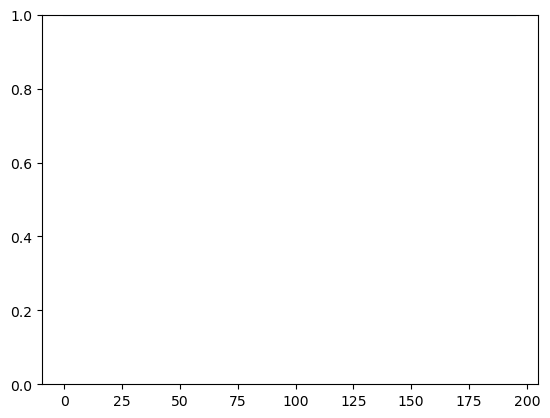

In [118]:
model_output = model(wanted_x_train_tensor)
embedding_output = embedding(wanted_x_train_tensor)
shapeg_output = shapeg(embedding_output)
scaleg_output = scaleg(embedding_output)
gate_output = gate(embedding_output)
plt.plot(loaded_model._model.predict_survival(np.array(wanted_x_train_tensor).astype(float), [400]))
plt.ylim(0, 1)
'''with open('180636_outputs.pkl', 'wb') as f:
    pickle.dump([wanted_x_train_tensor, model_output, embedding_output, shapeg_output, scaleg_output, gate_output, survival_output], f)'''

In [9]:
xrep = embedding.forward(wanted_x_train_tensor)
dim = x_train_tensor.shape[0]
print(a.act(shapeg(xrep))+a.shape['1'].expand(dim, -1),
           a.act(scaleg(xrep))+a.scale['1'].expand(dim, -1),
           gate(xrep)/a.temp)


torch.Size([1, 1000])
torch.Size([1, 3])
tensor([[0.9874, 1.0554, 1.0971]], grad_fn=<AddBackward0>) tensor([[1.1052, 0.9778, 0.9912]], grad_fn=<AddBackward0>) tensor([[ 0.1165,  0.0377, -0.0991]], grad_fn=<DivBackward0>)


In [105]:
from keras.models import load_model
x_train_keras = np.array(x_train_tensor)
embedding_keras = load_model('embedding.h5')
shapeg_keras = load_model('shapeg.h5')
scaleg_keras = load_model('scaleg.h5')
gate_keras = load_model('gate.h5')
print(x_train_keras.shape)
xred_keras = embedding_keras.predict(x_train_keras)

print(np.tanh(shapeg_keras.predict(xred_keras))+np.array([1,1,1]), 
      np.tanh(scaleg_keras.predict(xred_keras))+np.array([1,1,1]),
        gate_keras.predict(xred_keras))

(1, 179)
1/1 [==============================] - 0s 24ms/step
[[0.98744142 1.05535991 1.097114  ]] [[1.10518538 0.97778107 0.99118527]] [[ 0.11653557  0.03767988 -0.09908683]]
